In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna
import pickle
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score 

%load_ext autoreload
%autoreload 2

file_path = "../data/carotenoid_training_data.csv"
df = pd.read_csv(file_path)
INPUT_VARS = df.columns[:-1]
INPUT_VARS = list(INPUT_VARS.values)
RESPONSE_VARS = [df.columns[-1]]

print(f"Input variables: {INPUT_VARS}" f"\nResponse variable: {RESPONSE_VARS}")
print(f"Shape of the dataframe: {df.shape}")


# Calculate bounds of proteins
def get_bounds(df: pd.DataFrame, input_vars: list, epsilon: float = 0.10):
    bounds = pd.DataFrame(columns=input_vars)
    X = df[input_vars]
    for col in input_vars:
        MAX = X[col].max()
        MIN = X[col].min()
        DELTA = MAX - MIN
        lb = MIN - epsilon * DELTA
        ub = MAX + epsilon * DELTA
        if lb < 0:
            lb = 0
        bounds.loc["min", col] = lb
        bounds.loc["max", col] = ub
    return bounds


# Create train/test sets
df.sort_values(by="prod", ascending=False, inplace=True)
test = df[:3].copy()
train = df[3:].copy()

X_train = train.drop("prod", axis=1)
y_train = train["prod"].values.ravel()

X_test = test.drop("prod", axis=1)
y_test = test["prod"].values.ravel()

bounds = get_bounds(train, INPUT_VARS)
display(bounds)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Input variables: ['ERG8', 'ERG10', 'ERG12', 'ERG13', 'ERG19', 'ERG20', 'IDI1', 'tHMG1']
Response variable: ['prod']
Shape of the dataframe: (168, 9)


,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1
min,0,0,0,0,0,0,0,0
max,21.723829,21.762191,25.871048,23.314336,21.509215,22.215345,6.946964,20.623585


In [62]:
# try:
#     with open("../models/xgb_carotenoid.pkl", "rb") as f:
#         final_model = pickle.load(f)
#         final_model.fit(X_train, y_train)
# except FileNotFoundError:
#     # Define the objective function for Optuna
#     def objective(trial):
#         params = {
#             "objective": "reg:squarederror",
#             "eval_metric": "rmse",
#             "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
#             "lambda": trial.suggest_float("lambda", 1e-3, 1.0, log=True),
#             "alpha": trial.suggest_float("alpha", 1e-3, 1.0, log=True),
#             "max_depth": trial.suggest_int("max_depth", 1, 10),
#             "eta": trial.suggest_float("eta", 0.01, 1.0, log=True),
#             "gamma": trial.suggest_float("gamma", 1e-3, 1.0, log=True),
#             "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
#             "n_estimators": trial.suggest_int("n_estimators", 5, 300)
#         }
        
#         model = xgb.XGBRegressor(**params)
#         scores = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_squared_error")
#         return -scores.mean()

#     study = optuna.create_study(direction="minimize")
#     study.optimize(objective, n_trials=100, show_progress_bar=True)
#     best_params = study.best_params
#     best_score = study.best_value    
#     final_model = xgb.XGBRegressor(**best_params)
#     final_model.fit(X_train, y_train)
    
from sklearn.ensemble import RandomForestRegressor

try:
    with open("../models/rf_carotenoid.pkl", "rb") as f:
        final_model = pickle.load(f)
        final_model.fit(X_train, y_train)
except FileNotFoundError:
    # Define the objective function for Optuna
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 5, 300),
            "max_depth": trial.suggest_int("max_depth", 1, 10),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False])            
        }
        
        model = RandomForestRegressor(**params)
        scores = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_squared_error")
        return -scores.mean()

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100, show_progress_bar=True)
    best_params = study.best_params
    best_score = study.best_value    
    final_model = RandomForestRegressor(**best_params)
    final_model.fit(X_train, y_train)

    with open("../models/rf_carotenoid.pkl", "wb") as f:
        pickle.dump(final_model, f)        

[I 2024-02-06 11:10:24,223] A new study created in memory with name: no-name-637915c4-2109-4e00-9cba-c4ceb3ed8ba0


  0%|          | 0/100 [00:00<?, ?it/s]

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[I 2024-02-06 11:10:24,395] Trial 0 finished with value: 6.369633494509979 and parameters: {'n_estimators': 15, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'auto', 'bootstrap': True}. Best is trial 0 with value: 6.369633494509979.
[I 2024-02-06 11:10:24,733] Trial 1 finished with value: 6.494611475470902 and parameters: {'n_estimators': 103, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 6.369633494509979.


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[I 2024-02-06 11:10:25,280] Trial 2 finished with value: 7.233534138450884 and parameters: {'n_estimators': 231, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'auto', 'bootstrap': False}. Best is trial 0 with value: 6.369633494509979.
[I 2024-02-06 11:10:25,372] Trial 3 finished with value: 6.574339958078355 and parameters: {'n_estimators': 47, 'max_depth': 1, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 6.369633494509979.
[I 2024-02-06 11:10:25,731] Trial 4 finished with value: 6.5790112635326 and parameters: {'n_estimators': 224, 'max_depth': 1, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 6.369633494509979.
[I 2024-02-06 11:10:26,049] Trial 5 finished with value: 6.346676673445162 and parameters: {'n_estimators': 112, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[I 2024-02-06 11:10:27,096] Trial 7 finished with value: 6.444527946400783 and parameters: {'n_estimators': 264, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'auto', 'bootstrap': True}. Best is trial 6 with value: 6.279137014496718.
[I 2024-02-06 11:10:27,581] Trial 8 finished with value: 6.4267909460234405 and parameters: {'n_estimators': 199, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 6 with value: 6.279137014496718.
[I 2024-02-06 11:10:27,618] Trial 9 finished with value: 6.282011917251414 and parameters: {'n_estimators': 7, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 6 with value: 6.279137014496718.
[I 2024-02-06 11:10:27,887] Trial 10 finished with value: 6.456660204957679 and parameters: {'n_estimators': 154, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[I 2024-02-06 11:10:30,233] Trial 18 finished with value: 6.537211227160224 and parameters: {'n_estimators': 136, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 6 with value: 6.279137014496718.
[I 2024-02-06 11:10:30,379] Trial 19 finished with value: 6.403109132679862 and parameters: {'n_estimators': 47, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'auto', 'bootstrap': True}. Best is trial 6 with value: 6.279137014496718.
[I 2024-02-06 11:10:30,892] Trial 20 finished with value: 6.314842582987015 and parameters: {'n_estimators': 183, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 6 with value: 6.279137014496718.
[I 2024-02-06 11:10:31,282] Trial 21 finished with value: 6.3442688438372405 and parameters: {'n_estimators': 150, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'l

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[I 2024-02-06 11:10:33,132] Trial 28 finished with value: 6.419864752913177 and parameters: {'n_estimators': 120, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'auto', 'bootstrap': True}. Best is trial 23 with value: 6.276131045281989.


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[I 2024-02-06 11:10:33,842] Trial 29 finished with value: 6.36545934369214 and parameters: {'n_estimators': 300, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 23 with value: 6.276131045281989.
[I 2024-02-06 11:10:33,964] Trial 30 finished with value: 6.599929205359534 and parameters: {'n_estimators': 31, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'auto', 'bootstrap': True}. Best is trial 23 with value: 6.276131045281989.
[I 2024-02-06 11:10:34,401] Trial 31 finished with value: 6.280099593645713 and parameters: {'n_estimators': 154, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 23 with value: 6.276131045281989.
[I 2024-02-06 11:10:34,873] Trial 32 finished with value: 6.427926205376494 and parameters: {'n_estimators': 209, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[I 2024-02-06 11:10:37,171] Trial 38 finished with value: 6.455982232186216 and parameters: {'n_estimators': 226, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'auto', 'bootstrap': True}. Best is trial 23 with value: 6.276131045281989.
[I 2024-02-06 11:10:37,376] Trial 39 finished with value: 6.4186700849985 and parameters: {'n_estimators': 73, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True}. Best is trial 23 with value: 6.276131045281989.
[I 2024-02-06 11:10:37,769] Trial 40 finished with value: 6.464283631695139 and parameters: {'n_estimators': 171, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 23 with value: 6.276131045281989.
[I 2024-02-06 11:10:38,205] Trial 41 finished with value: 6.361671328052249 and parameters: {'n_estimators': 159, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': '

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[I 2024-02-06 11:10:43,980] Trial 55 finished with value: 6.404029543827118 and parameters: {'n_estimators': 179, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'auto', 'bootstrap': True}. Best is trial 47 with value: 6.273898853696269.
[I 2024-02-06 11:10:44,441] Trial 56 finished with value: 6.5287583997606085 and parameters: {'n_estimators': 194, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': False}. Best is trial 47 with value: 6.273898853696269.
[I 2024-02-06 11:10:44,606] Trial 57 finished with value: 6.552034413177136 and parameters: {'n_estimators': 56, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 47 with value: 6.273898853696269.
[I 2024-02-06 11:10:44,921] Trial 58 finished with value: 6.400682628630066 and parameters: {'n_estimators': 119, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_feature

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[I 2024-02-06 11:10:47,930] Trial 66 finished with value: 6.340256756162371 and parameters: {'n_estimators': 145, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'auto', 'bootstrap': True}. Best is trial 47 with value: 6.273898853696269.
[I 2024-02-06 11:10:48,279] Trial 67 finished with value: 6.479777545136778 and parameters: {'n_estimators': 134, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 47 with value: 6.273898853696269.
[I 2024-02-06 11:10:48,568] Trial 68 finished with value: 6.393478634537504 and parameters: {'n_estimators': 75, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': True}. Best is trial 47 with value: 6.273898853696269.
[I 2024-02-06 11:10:48,672] Trial 69 finished with value: 6.620942724245393 and parameters: {'n_estimators': 19, 'max_depth': 1, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[I 2024-02-06 11:10:53,440] Trial 78 finished with value: 7.3740039952007805 and parameters: {'n_estimators': 176, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'auto', 'bootstrap': False}. Best is trial 71 with value: 6.255448339066448.
[I 2024-02-06 11:10:54,122] Trial 79 finished with value: 6.317625257443482 and parameters: {'n_estimators': 212, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}. Best is trial 71 with value: 6.255448339066448.
[I 2024-02-06 11:10:54,609] Trial 80 finished with value: 6.374032029305634 and parameters: {'n_estimators': 190, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 71 with value: 6.255448339066448.
[I 2024-02-06 11:10:55,094] Trial 81 finished with value: 6.3310372217939195 and parameters: {'n_estimators': 197, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_featu

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[I 2024-02-06 11:11:03,300] Trial 99 finished with value: 6.422056548751779 and parameters: {'n_estimators': 117, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'auto', 'bootstrap': True}. Best is trial 71 with value: 6.255448339066448.


In [64]:
def bootstrap(X, y, model: object, n: int = 100):
    mae_values = []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.30, random_state=i
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae_values.append(mean_absolute_error(y_test, y_pred))
    return mae_values

mae_values = bootstrap(X_train, y_train, final_model)
print(f"Bootstraped Mean(MAE) = {np.mean(mae_values)}")
final_model.fit(X_train, y_train)

with open("../models/xgb_carotenoid.pkl", "wb") as f:
    final_model.fit(X_train, y_train)
    pickle.dump(final_model, f)

100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Bootstraped Mean(MAE) = 1.3154130952103928


#### Explainable AI 

ExactExplainer explainer: 166it [00:14,  3.47it/s]                         


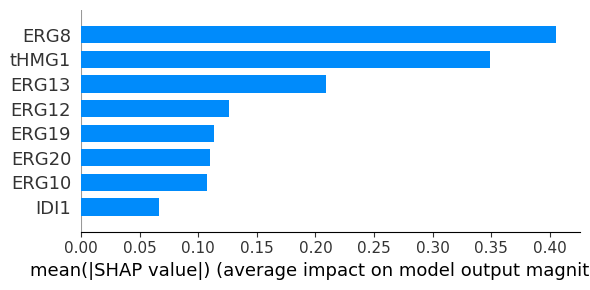

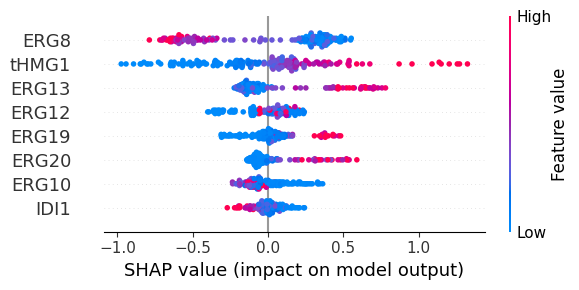

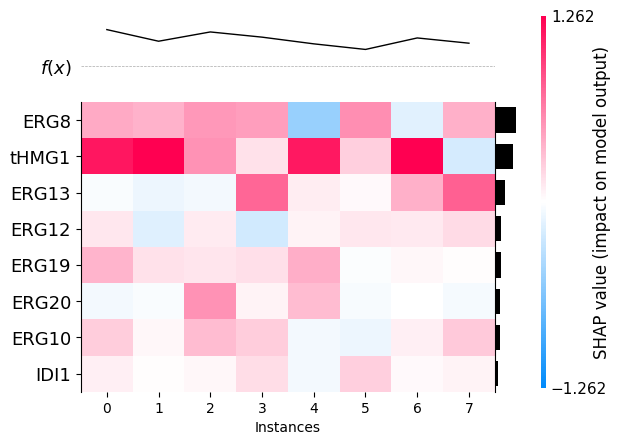

In [65]:
import shap
import matplotlib.pyplot as plt
from alibi.explainers import ALE, PartialDependence, plot_ale, plot_pd

def pdplot(X: np.array, col: str, model: object, ice: bool = False):
    shap.plots.partial_dependence(
        col,
        model.predict,
        X,
        ice=ice,
        model_expected_value=True,
        feature_expected_value=True,
        show=True,
    )


def shap_scatter(feature: str, color=None):
    if color:
        shap.plots.scatter(shap_values[:, feature], color=shap_values[:, color])
    else:
        shap.plots.scatter(shap_values[:, feature])


explainer = shap.Explainer(final_model.predict, train[INPUT_VARS])
shap_values = explainer(train[INPUT_VARS])
shap.summary_plot(shap_values, train[INPUT_VARS], plot_type="bar", plot_size=(6, 3))
shap.summary_plot(shap_values, train[INPUT_VARS], plot_type="dot", plot_size=(6, 3))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(0), plot_width=6)

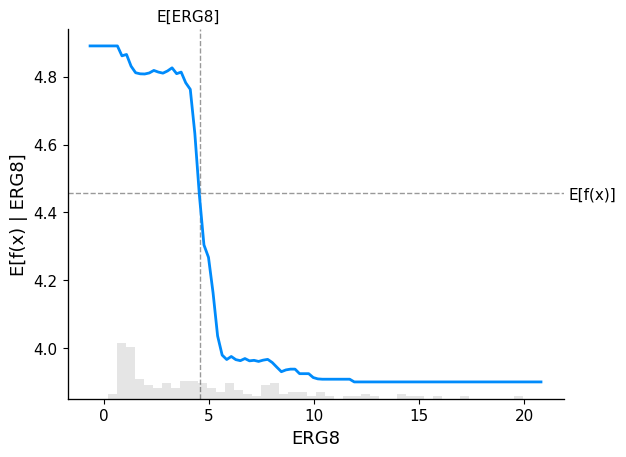

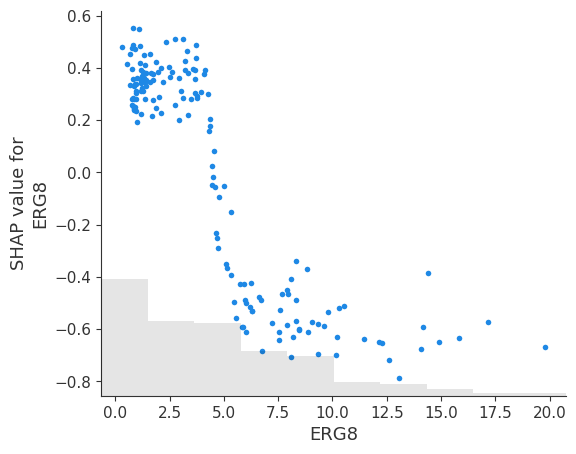

In [68]:
feature = "ERG8"
pdplot(train[INPUT_VARS], feature, final_model, ice=False)
shap_scatter(feature)

In [57]:
test

,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1,prod
159,8.055299,6.361974,2.989112,10.030468,2.530277,1.613322,1.603377,12.883930,10.563800
117,4.382417,1.525546,1.180070,1.533178,1.411179,1.349900,1.508734,19.775550,10.401666
155,7.336543,3.662594,7.673811,2.682688,2.195583,4.418530,1.014994,13.672108,9.522851


In [ ]:
idx = 2
shap.plots.waterfall(shap_values[idx])

# Sampling

In [69]:
sampling_bounds = pd.DataFrame(columns=bounds.columns, index=bounds.index)

sampling_bounds["ERG8"].loc["min"] = bounds["ERG8"].loc["min"]
sampling_bounds["ERG8"].loc["max"] = 5

sampling_bounds["ERG10"].loc["min"] = 1.75
sampling_bounds["ERG10"].loc["max"] = bounds["ERG10"].loc["max"]

sampling_bounds["ERG12"].loc["min"] = bounds["ERG12"].loc["min"]
sampling_bounds["ERG12"].loc["max"] = 1.0

sampling_bounds["ERG13"].loc["min"] = 10
sampling_bounds["ERG13"].loc["max"] = bounds["ERG13"].loc["max"]

sampling_bounds["ERG19"].loc["min"] = bounds["ERG19"].loc["min"]
sampling_bounds["ERG19"].loc["max"] = 0.7

sampling_bounds["ERG20"].loc["min"] = 3.0
sampling_bounds["ERG20"].loc["max"] = bounds["ERG20"].loc["max"]

sampling_bounds["IDI1"].loc["min"] = bounds["IDI1"].loc["min"]
sampling_bounds["IDI1"].loc["max"] = 0.6

sampling_bounds["tHMG1"].loc["min"] = 17
sampling_bounds["tHMG1"].loc["max"] = bounds["tHMG1"].loc["max"]


# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(100)
LB = sampling_bounds.T["min"].values.tolist()
UB = sampling_bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["pred"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)
sample_df.head(10)

,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1,pred
48,0.806600,9.326464,0.604153,11.276064,0.114421,9.673720,0.015208,17.345097,6.180502
43,0.861657,21.339377,0.495204,11.729179,0.049565,14.181084,0.032664,19.640693,6.172616
55,2.099781,16.015939,0.036787,11.530509,0.235709,16.334323,0.233996,19.651362,6.167003
34,2.155908,16.602248,0.107275,12.227720,0.484561,21.434793,0.493838,19.461919,6.159272
76,0.038648,8.475271,0.279145,12.391360,0.637037,15.360626,0.335006,17.792591,6.157077
52,1.110571,8.018394,0.207712,11.015075,0.005620,19.106536,0.004499,18.918329,6.153968
33,2.019507,13.325847,0.989098,11.978227,0.349450,20.790003,0.198034,19.280875,6.151642
97,0.331557,11.010761,0.828217,13.872283,0.463649,15.179141,0.566808,20.478363,6.145610
35,1.439674,10.528536,0.533068,10.863327,0.144863,21.674588,0.212069,17.373797,6.143006
44,0.697774,8.565257,0.551291,13.667727,0.367041,16.934942,0.104931,17.165004,6.139029


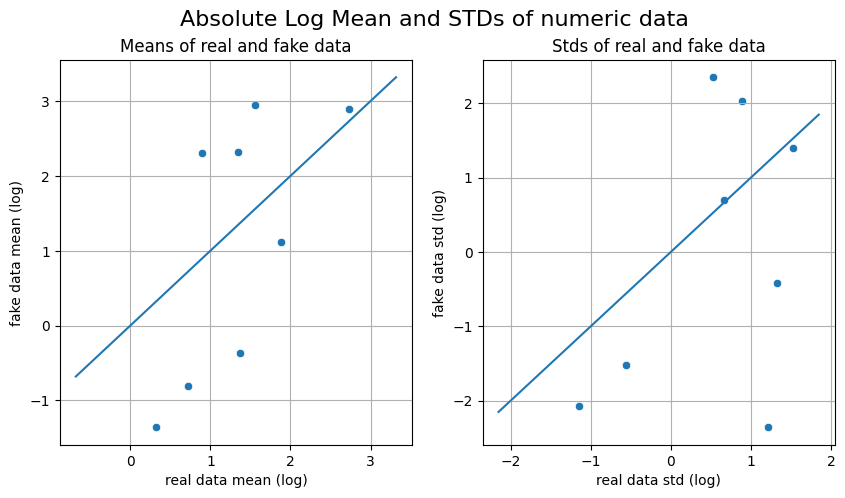

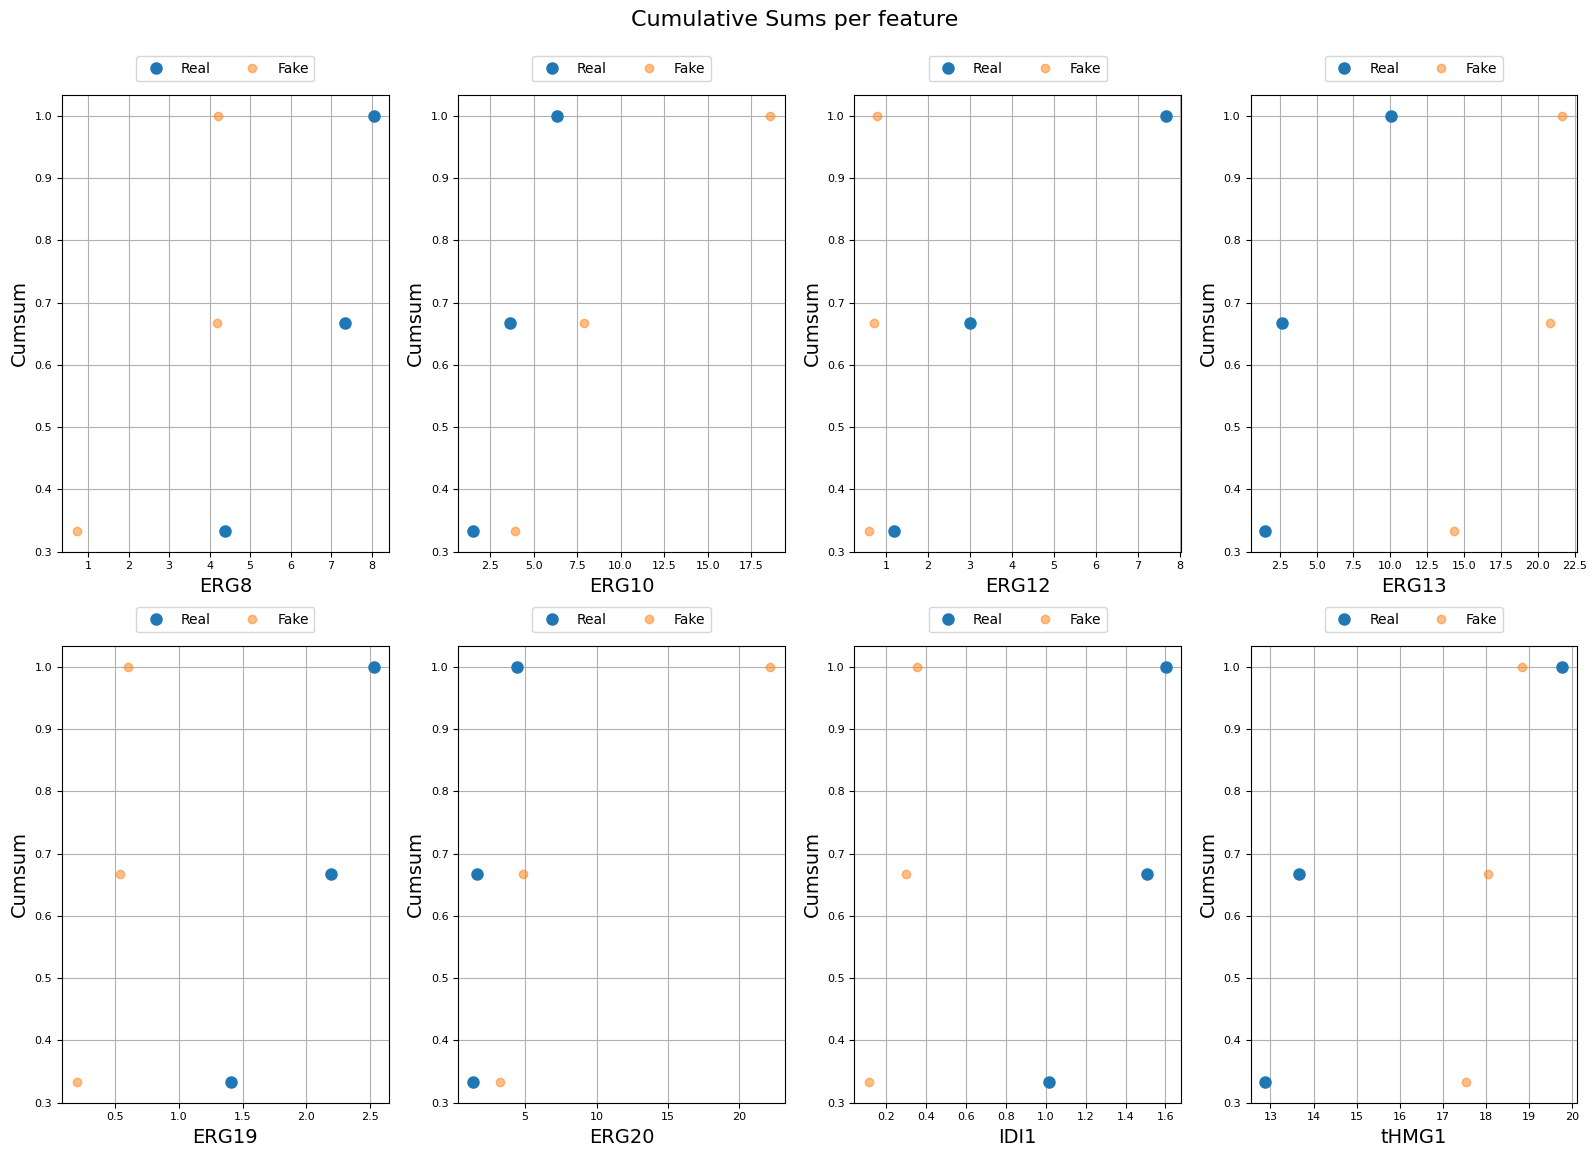

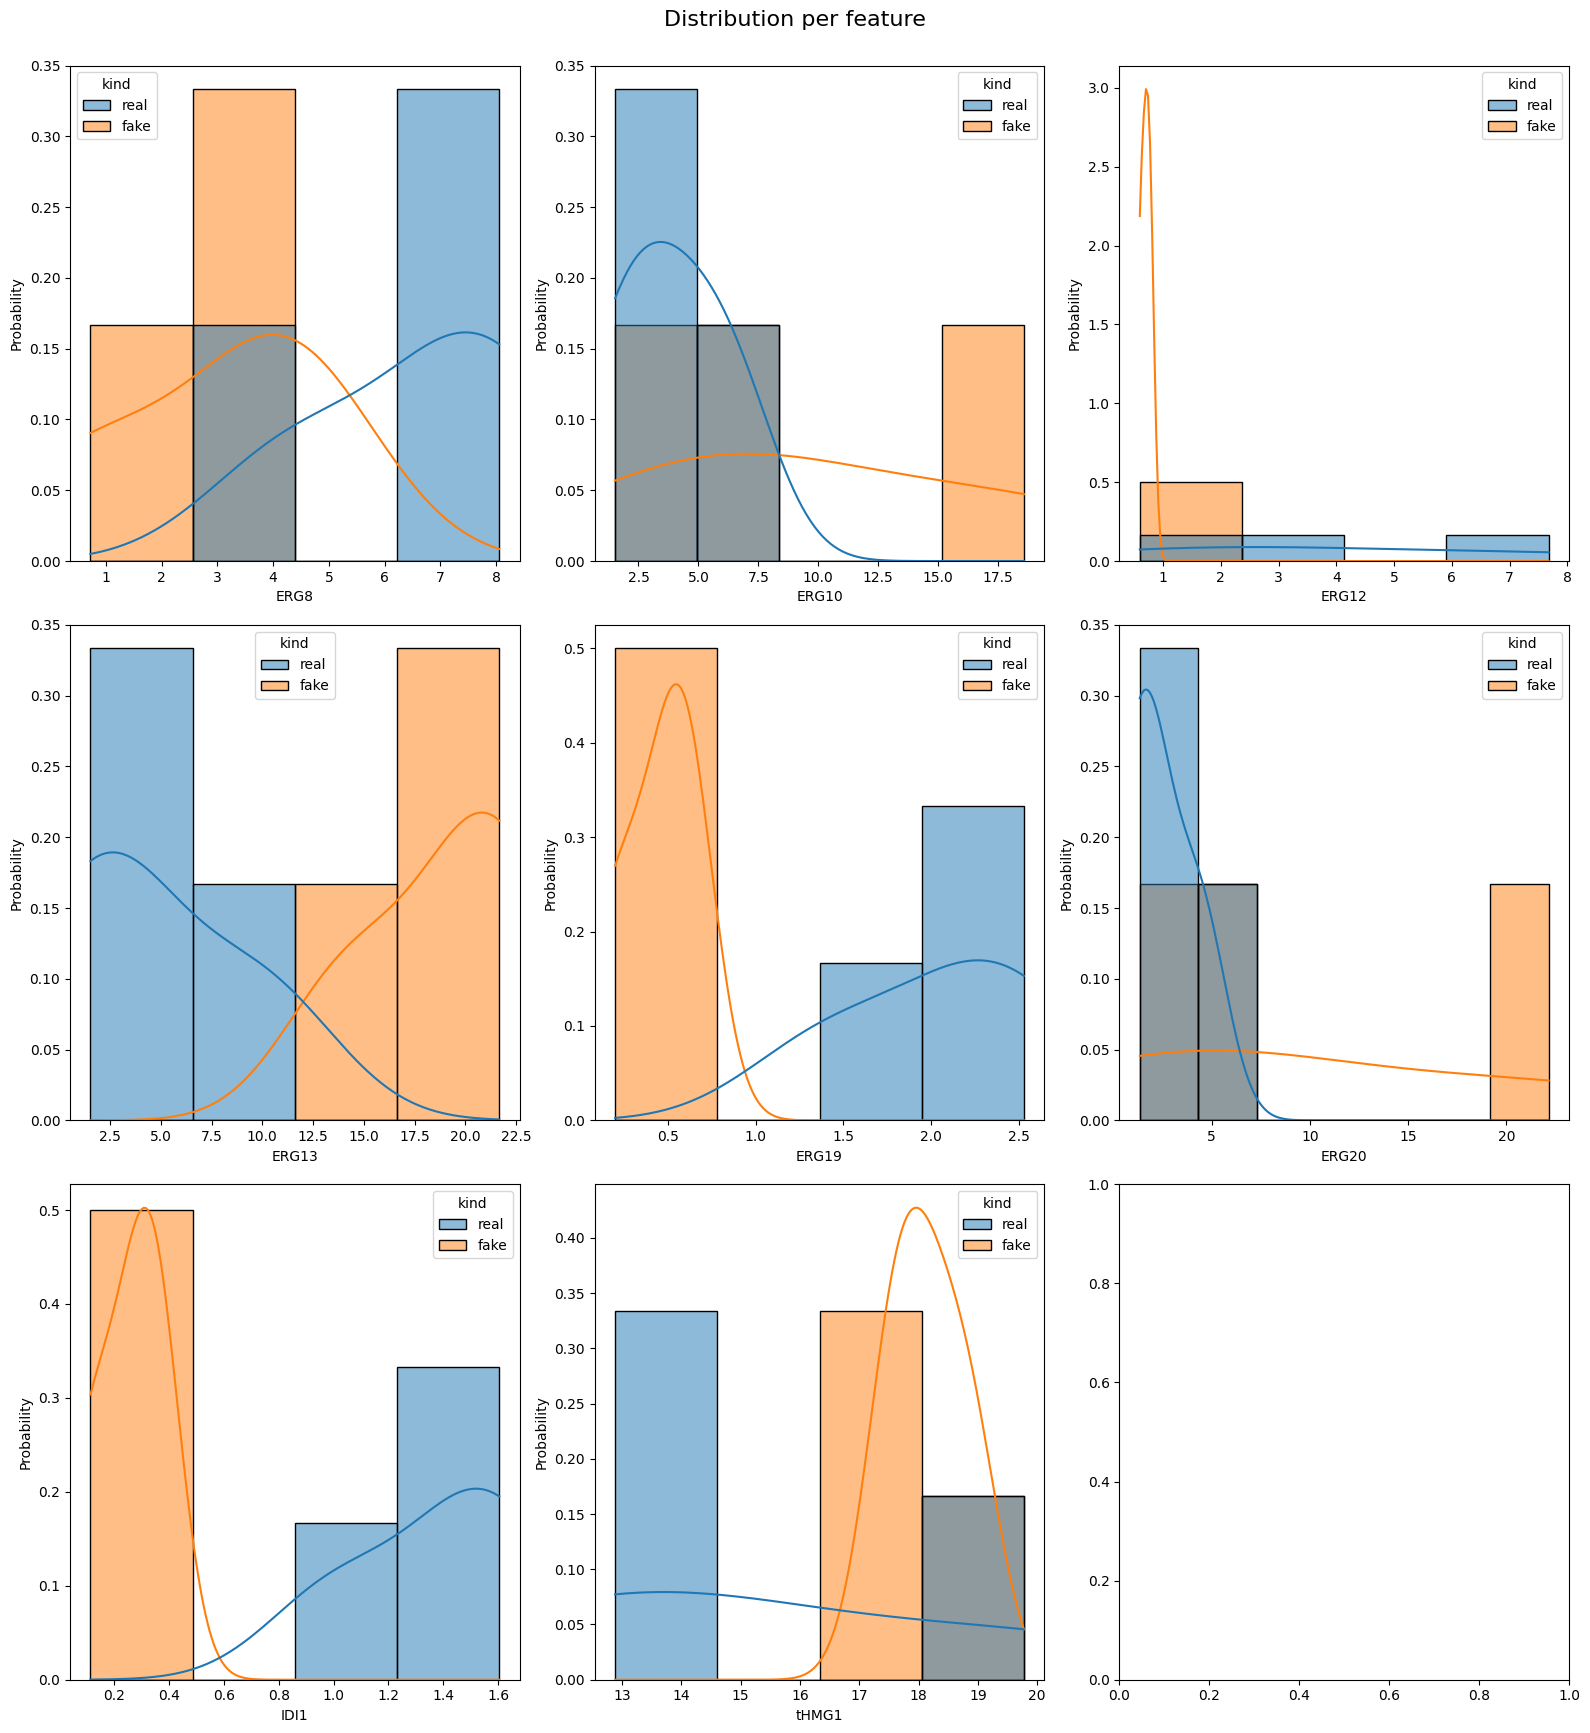

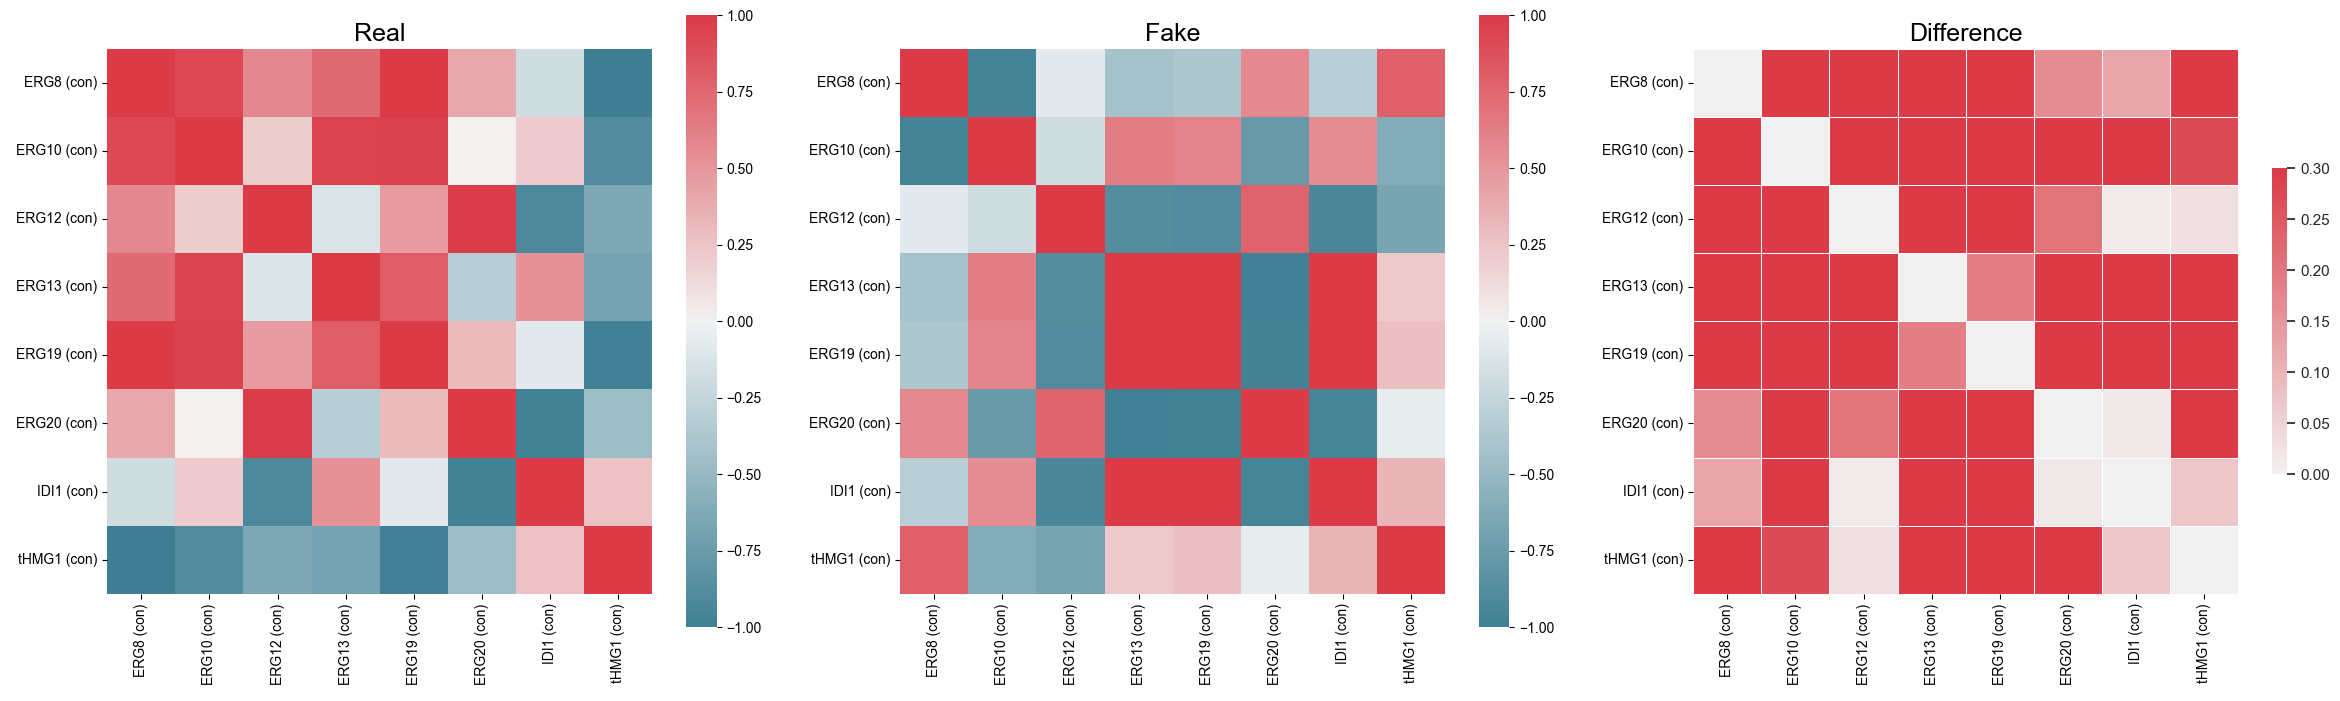

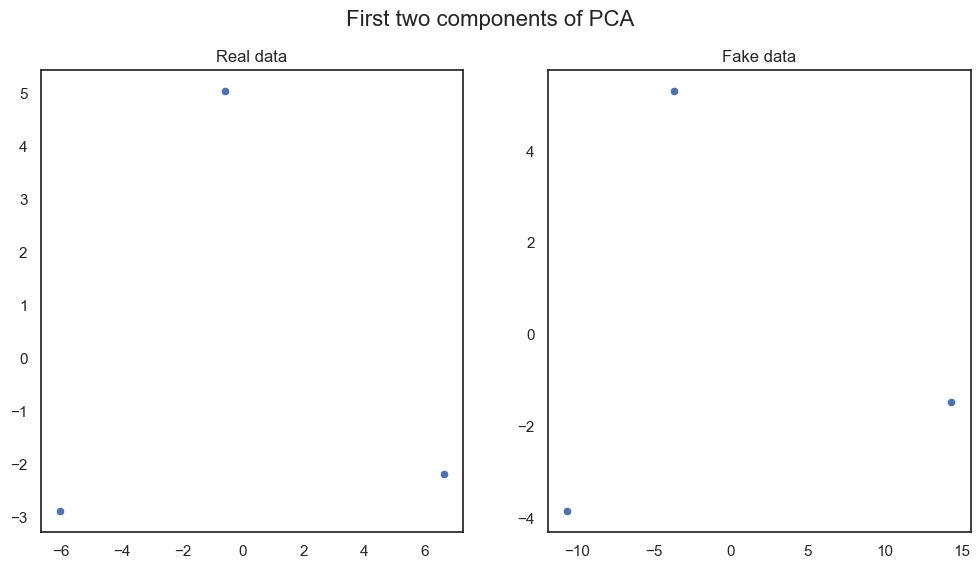

In [70]:
from table_evaluator import TableEvaluator

real_samples = test[INPUT_VARS]
table_evaluator = TableEvaluator(real_samples, sample_df[INPUT_VARS])
table_evaluator.visual_evaluation()

# Counterfactuals (`DiCE`)

In [91]:
import dice_ml
from dice_ml.utils import helpers

sorted_idx = train.sort_values("prod", ascending=False).index
X_train = X_train.loc[sorted_idx]

def bounds_to_dict(bounds: pd.DataFrame):
    bounds_dict = bounds.to_dict()
    bounds_dict = {k: [v["min"], v["max"]] for k, v in bounds_dict.items()}
    return bounds_dict


query_instances = X_train[0:1]

d = dice_ml.Data(
    dataframe=train, continuous_features=INPUT_VARS, outcome_name=RESPONSE_VARS[0]
)
m = dice_ml.Model(model=final_model, backend="sklearn", model_type="regressor")
exp = dice_ml.Dice(d, m, method="genetic")
e1 = exp.generate_counterfactuals(
    query_instances,
    total_CFs=10,
    desired_range=[5, 9],
    permitted_range=bounds_to_dict(sampling_bounds),
)

cf_df = e1.cf_examples_list[0].final_cfs_df
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

Query instance (original outcome : 6.250035285949707)


,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1,prod
0,0.322517,1.081516,0.214028,11.495731,1.872004,1.773278,0.470616,2.94563,6.250035



Diverse Counterfactual set (new outcome: [5, 9])


,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1,prod
0,-,2.0296011,-,-,0.19368254,11.40151234,-,17.0,6.189909354833521
0,0.0,1.75,-,-,0.69867491,3.0,-,18.96364009,6.135789419143478
0,-,21.22874893,-,-,0.5704848,5.34342296,-,17.76109751,6.099847781056986
0,0.0,1.75,-,-,0.0,3.0,-,17.0,6.11219124592745
0,0.0,1.75,-,-,0.0,3.0,-,18.61388722,6.11219124592745
0,0.0,1.75,-,-,0.05956028,3.0,-,19.17005638,6.11219124592745
0,0.0,1.75,-,-,0.0,3.0,-,19.17005638,6.11219124592745
0,0.80805564,1.75,-,-,0.0,3.47815788,-,18.80913925,6.094626560014796
0,0.0,4.68415213,-,-,0.0,3.0,-,17.0,6.066147618903969
0,0.17855984,1.75,-,-,0.0,3.8080793,-,20.23163856,6.11219124592745


# PCA

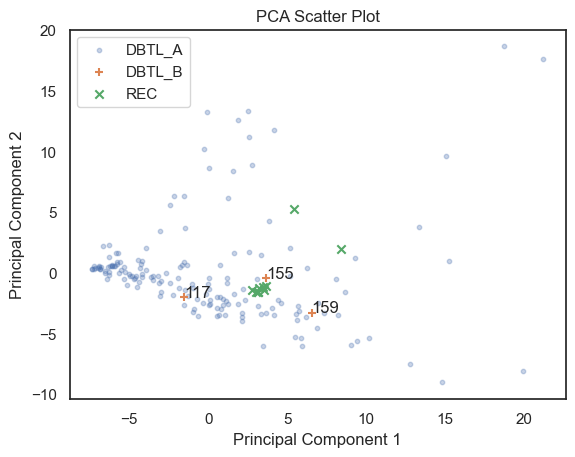

          prod
159  10.563800
117  10.401666
155   9.522851


In [92]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

pca = PCA(n_components=2)
pca.fit(train[INPUT_VARS])
trans_df_A = pca.transform(train[INPUT_VARS])
trans_df_B = pca.transform(test[INPUT_VARS])
trans_rec = pca.transform(cf_df[INPUT_VARS])

# Plot
plt.scatter(trans_df_A[:, 0], trans_df_A[:, 1], label="DBTL_A", alpha=0.3, s=10)
plt.scatter(trans_df_B[:, 0], trans_df_B[:, 1], label="DBTL_B", marker='+')
for i, txt in enumerate(test.index):
    plt.annotate(txt, (trans_df_B[i, 0], trans_df_B[i, 1]))
plt.scatter(trans_rec[:, 0], trans_rec[:, 1], label="REC", marker='x')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot")
plt.legend()
plt.show()

print(test[RESPONSE_VARS].sort_values(by='prod', ascending=False))